# Springboard - Data Science Career Track

## Project: Example Take-Home Challenge: Relax Inc.

The data is available as two attached CSV files:
 - takehome_user_engagement. csv
 - takehome_users . csv

The data has the following two tables:

 - **1]** A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
     - name: the user's name
     - object_id: the user's id
     - email: email address
     - creation_source: how their account was created. This takes on oneof 5 values:
         - PERSONAL_PROJECTS: invited to join another user's personal workspace
         - GUEST_INVITE: invited to an organization as a guest (limited permissions)
         - ORG_INVITE: invited to an organization (as a full member)
         - SIGNUP: signed up via the website
         - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
    - creation_time: when they created their account
    - last_session_creation_time: unix timestamp of last login
    - opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    - enabled_for_marketing_drip: whether they are on the regular marketing email drip
    - org_id: the organization (group of users) they belong to
    - invited_by_user_id: which user invited them to join (if applicable).

 - **2]** A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption. We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any  summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import timedelta

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

Takehome user engagement dataframe

In [2]:
# takehome_user_engagement dataframe
takehome_user_engagement = pd.read_csv('takehome_user_engagement.csv')

print(takehome_user_engagement.shape, "\n")
print(takehome_user_engagement.info())
takehome_user_engagement.head()

(207917, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
# Data cleaning
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp']) # convert to datetime
takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [4]:
# check if there are only 1's
takehome_user_engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

<div class="span5 alert alert-info">
    <b>Definition of adopted user:</b>

  - *a user who has logged into the product on three separate days in at least one seven day period*
</div>

In [5]:
# new dataframe and sort by date & days
df = takehome_user_engagement.sort_values('time_stamp').reset_index(drop=True)
df['time_stamp'] = pd.to_datetime([df['time_stamp'].iloc[i].strftime("%Y/%m/%d") for i in range(len(df))])
df.head()

,time_stamp,user_id,visited
0,2012-05-31,10012,1
1,2012-05-31,3428,1
2,2012-05-31,9899,1
3,2012-05-31,1693,1
4,2012-06-01,6102,1


In [6]:
# number of days between first and last
df.time_stamp.max() - df.time_stamp.min()

Timedelta('736 days 00:00:00')

In [7]:
%%time
# define adopted_user

from datetime import timedelta

initial_adopted_users = []

for i in range(1, 736):
    
    # create dataframe between 2 dates iteratively
    interval_df = df[(df['time_stamp'] <= df.time_stamp.min() + timedelta(i)) & 
                     (df['time_stamp'] > df.time_stamp.min() + timedelta(i-7))]
    
    # get only logins in separate days
    
    users_day = []
    for j in set(interval_df.time_stamp):
        users_day.append(interval_df[interval_df['time_stamp'] == j].user_id.unique()) 
    
    one_list = []
    for sublist in users_day:
        for i in sublist:
            one_list.append(i)
            
    ###
    
    # check the users that logged into the product on three separate days in this period
    interval_df = pd.Series(one_list).value_counts() == 3
    
    # append to the list of adopted users
    initial_adopted_users.append(interval_df.index[:interval_df.sum()].tolist())
    

# from the resulting list, create unique list with adopted users 
flat_list = []
for sublist in initial_adopted_users:
    for i in sublist:
        flat_list.append(i)

# adopted users
adopted_users = set(flat_list)

Wall time: 16.1 s


In [8]:
# number of adopted users & percentage
print("The number of adopted users is {}.".format(len(adopted_users)))
print("The percentage of adopted users is {}%.".format(round(len(adopted_users)/len(df['user_id'].unique())*100, 1)))

The number of adopted users is 791.
The percentage of adopted users is 9.0%.


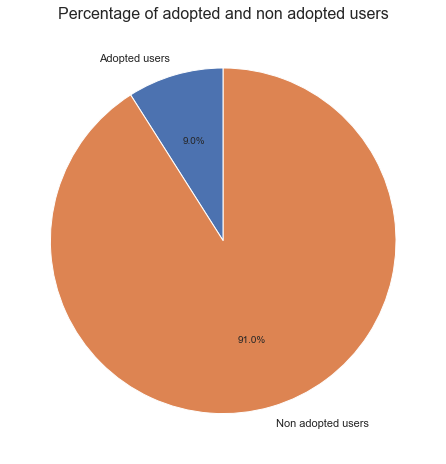

In [9]:
# pie plot

# define sizes
size_adopted = round(len(adopted_users)/len(df['user_id'].unique()), 3)
size_nonadopted = 1 - size_adopted

# formatting
labels = ["Adopted users", "Non adopted users"]
sizes = [size_adopted, size_nonadopted]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Percentage of adopted and non adopted users", fontsize=16)
plt.ylabel("")

plt.subplots_adjust(left=0, bottom=-0.5, right=1, top=1, wspace=0, hspace=0)
plt.show()

Takehome users dataframe

In [10]:
# takehome_users dataframe
takehome_users = pd.read_csv('takehome_users.csv', encoding='latin-1')

print(takehome_users.shape, "\n")
print(takehome_users.info())

takehome_users.head()

(12000, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [11]:
# Data cleaning
takehome_users['creation_time'] = pd.to_datetime(takehome_users['creation_time']) # convert to datetime
takehome_users.invited_by_user_id.fillna(0, inplace=True)  # replace NaN with 0
takehome_users.last_session_creation_time.fillna(0, inplace=True)  # replace NaN with 0
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [12]:
# add adopted user column (is_adopted)
is_adopted = []

for i in takehome_users['object_id']:
    if i in adopted_users:
        is_adopted.append(1)
    else:
        is_adopted.append(0)
        
takehome_users['is_adopted'] = is_adopted
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [13]:
# check
takehome_users.is_adopted.value_counts()

0    11209
1      791
Name: is_adopted, dtype: int64

### Exploratory Data analysis

**1) Creation source**

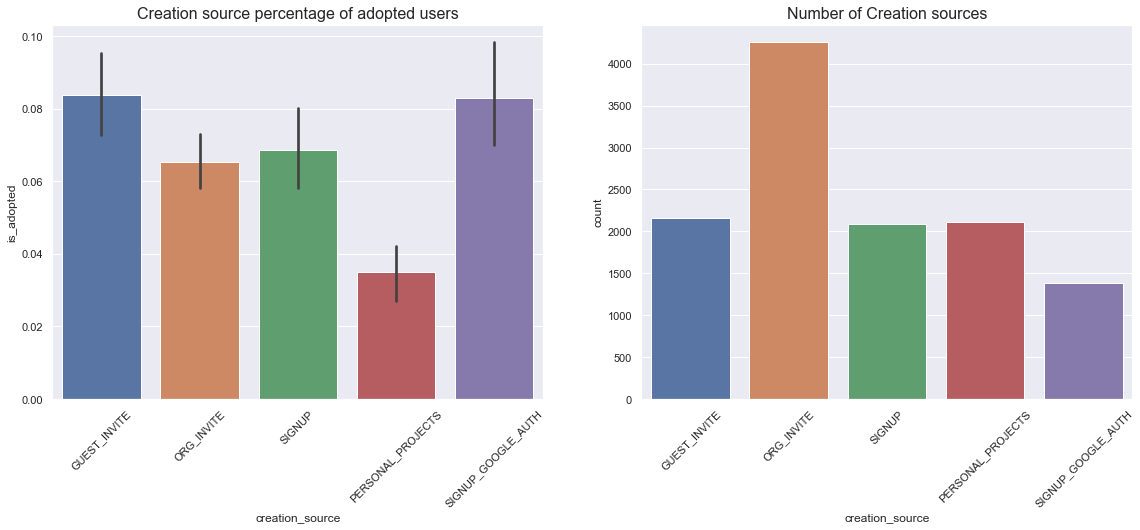

In [14]:
# Creation source percentage of adopted users
plt.subplot(1, 2, 1)
sns.barplot(x="creation_source", y="is_adopted", data=takehome_users)
plt.title('Creation source percentage of adopted users', fontsize=16)
plt.xticks(rotation=45)

# countplot creation sources
plt.subplot(1, 2, 2)
sns.countplot(takehome_users.creation_source)
plt.title('Number of Creation sources', fontsize=16)
plt.xticks(rotation=45)

plt.subplots_adjust(left=0, bottom=-0.3, right=2.5, top=1, wspace=0.2, hspace=0)
plt.show()

In [15]:
# absolute values
takehome_users[takehome_users['is_adopted'] == 1].creation_source.value_counts()

ORG_INVITE            278
GUEST_INVITE          181
SIGNUP                143
SIGNUP_GOOGLE_AUTH    115
PERSONAL_PROJECTS      74
Name: creation_source, dtype: int64

We see that although we have more adopted users that were invited to an organization (ORG_INVITE), the most effective source is in fact when a user is invited to an organization as a guest (GUEST_INVITE), which gets a higher percentage of adopted users.

**2) Opted in to mailing list**

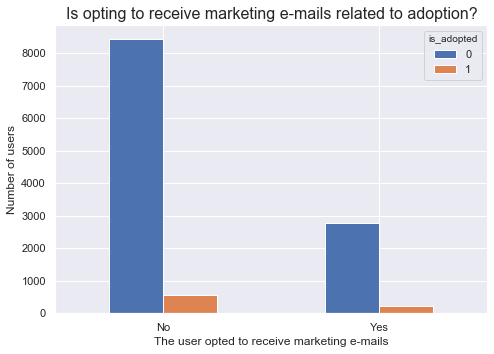

In [16]:
# crosstab plot
pd.crosstab(takehome_users['opted_in_to_mailing_list'], takehome_users['is_adopted']).plot(kind='bar')
plt.title('Is opting to receive marketing e-mails related to adoption?', fontsize=16)
plt.xlabel('The user opted to receive marketing e-mails')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Number of users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show()

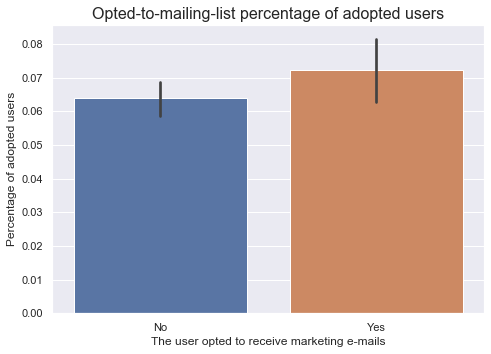

In [17]:
# percentage of adopted users
sns.barplot(x="opted_in_to_mailing_list", y="is_adopted", data=takehome_users)
plt.title('Opted-to-mailing-list percentage of adopted users', fontsize=16)
plt.xlabel('The user opted to receive marketing e-mails')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Percentage of adopted users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show()

There is a slightly higher tendency to become an adopted user if he/she decided to receive marketing e-mails. Should we have expected a higher margin for adoption given that the user demonstrated his/her interest?

**3) Enabled for marketing drip**

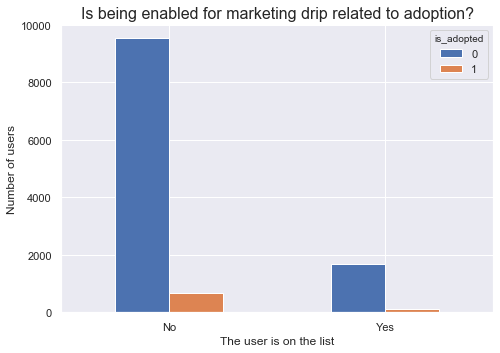

In [18]:
# crosstab plot
pd.crosstab(takehome_users['enabled_for_marketing_drip'], takehome_users['is_adopted']).plot(kind='bar')
plt.title('Is being enabled for marketing drip related to adoption?', fontsize=16)
plt.xlabel('The user is on the list')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Number of users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show()

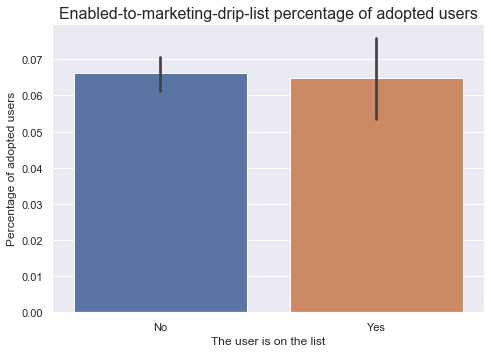

In [19]:
# percentage of adopted users
sns.barplot(x="enabled_for_marketing_drip", y="is_adopted", data=takehome_users)
plt.title('Enabled-to-marketing-drip-list percentage of adopted users', fontsize=16)
plt.xlabel('The user is on the list')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Percentage of adopted users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show()

It's practically indifferent if the user regularly receives marketing e-mails or not.

**4) Group of users id**

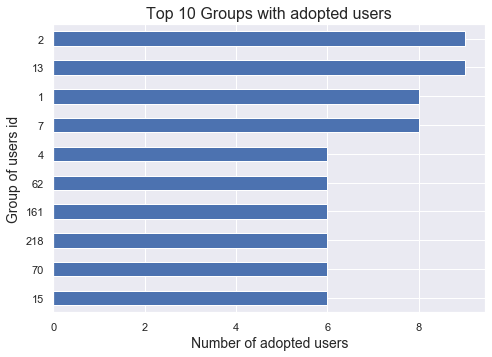

In [20]:
n = 10

# plot top group user id's
takehome_users[takehome_users['is_adopted'] == 1].org_id.value_counts(ascending=True)[-n:].plot(kind='barh')
plt.title("Top {} Groups with adopted users".format(n), fontsize=16)
plt.ylabel("Group of users id", fontsize=14)
plt.xlabel("Number of adopted users", fontsize=14)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show()

These are the groups which concentrate more adopted users.

### Predict future user adoption

In [21]:
# transform the data to operate with 
tk_df = takehome_users.copy().drop(['name', 'email', 'last_session_creation_time'], axis=1)
tk_df['creation_time'] = scale(tk_df['creation_time'])

tk_df = pd.get_dummies(tk_df)
tk_df.head()

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,object_id,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1.290656,1,0,11,10803.0,0,1,0,0,0,0
1,2,0.561296,0,0,1,316.0,0,0,1,0,0,0
2,3,-0.547419,0,0,94,1525.0,0,0,1,0,0,0
3,4,-0.259511,0,0,1,5151.0,0,1,0,0,0,0
4,5,-0.831499,0,0,193,5240.0,0,1,0,0,0,0


In [22]:
# binary target
y = tk_df['is_adopted']

# exclude not relevant features, get dummy variables and normalize
X = tk_df.drop('is_adopted', axis=1)

# Split into train (70%) and test (30%) sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [23]:
# for reproducibility
SEED = 10

**Extreme Gradient Boosting (XGBoost)**

In [24]:
%%time
import xgboost as xgb

# instantiate the model
clf_xgb = xgb.XGBClassifier(random_state=SEED, n_estimators=10)

# train the model
clf_xgb.fit(X_train, y_train)

Wall time: 116 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
model = clf_xgb
model_name = 'XGBClassifier'

In [26]:
# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.9341666666666667

Confusion matrix:
 [[2242    0]
 [ 158    0]]

Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97      2242
           1       0.00      0.00      0.00       158

    accuracy                           0.93      2400
   macro avg       0.47      0.50      0.48      2400
weighted avg       0.87      0.93      0.90      2400


AUC: 0.7610759493670887


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We get a score of 93.4% and a AUC of 0.76, which is good.

After doing feature selection with PCA and RFE analysis, I decided to keep all the features. The change in score was not significant.

Now let us look at the most relevant features for predicting future adoption:

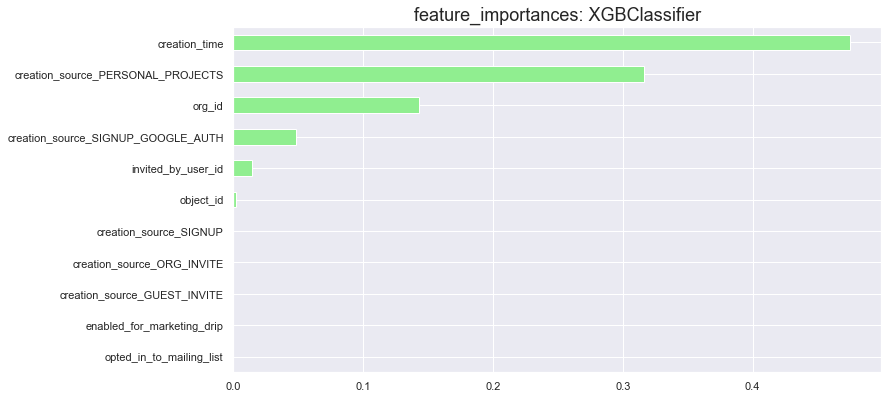

In [27]:
# X columns
X_columns = X.columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=model.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format('XGBClassifier'), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

We see that an obvious variable is the **creation time**, that is, the early accounts get the highest probability of becoming adopted, which could also be a recommendation for Relax Inc. to be patient. In any case, that is not enough per se. 

The **creation source** seems to be an important feature. As we have seen, although we have more adopted users that were invited to an organization (ORG_INVITE), the most effective source is in fact when a user is invited to an organization as a guest (GUEST_INVITE), which gets a higher percentage of adopted users. A special case is if the account was created by invitation to join another user's personal workspace (PERSONAL PROJECTS): this is the least effective tactic and the best predictor for future not user adoption.

On a less important tone, the **organization (group of users)** a user belongs to seems to be a good indicator as well. Belonging to active user groups could encourage future adoption. 

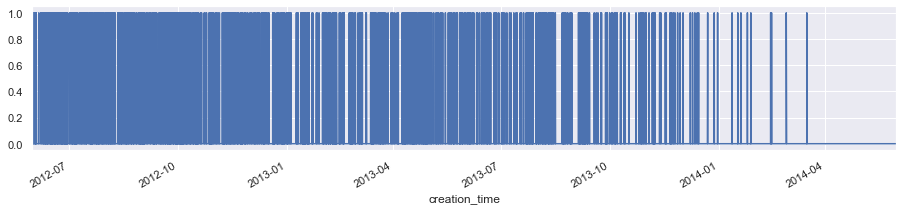

In [28]:
# adopted users date of creation account
takehome_users.groupby('creation_time').sum()['is_adopted'].plot()
plt.subplots_adjust(left=0, bottom=0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

**END**